In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn import metrics
from itertools import product
from scipy.linalg import pinv
import warnings
import time
from collections import defaultdict
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import GaussianRandomProjection
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
results=[['Precision', 'Recall', 'Accuracy', 'Balanced Accuracy','Time']]

In [27]:
df = pd.read_csv('/Users/qingzhou/Desktop/GT_OMSCS/Machine_Learning_CS7641/assignment_1/winequality-white.csv')
df.isnull().sum()
x_features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
y_output = ['quality']
class_name = ['bad', 'good']
data = df
df_x, df_y = data[x_features], data[y_output]
df_y['quality'].mask(df['quality'] <=5, 0, inplace= True)
df_y['quality'].mask(df['quality'] >=6, 1, inplace= True)
sc = StandardScaler()
X_train, X_test, Y_train, Y_test = train_test_split(df_x, df_y, test_size=0.2)
X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
df_x.shape

(4898, 11)

In [3]:
def prediction(pred, y):
    return metrics.precision_score(y, pred), metrics.recall_score(y, pred), metrics.accuracy_score(y, pred), metrics.confusion_matrix(y, pred), metrics.balanced_accuracy_score(y, pred)

In [4]:
def learning(model, x, y, folds, model_name):
    
    size, train, val, fit, _ = learning_curve(model, x, y, cv=folds, return_times=True)
    _, axes = plt.subplots(1, 3, figsize=(20, 5))
    plt.grid(False)
    axes[0].set_title('Learning Curve of ' + model_name)
    axes[0].set_xlabel("Training Number")
    axes[0].set_ylabel("Accuracy")
#     print(train)
#     print(val)
    train_mean = np.mean(train, axis=1)
    train_std = np.std(train, axis=1)
    val_mean = np.mean(val, axis=1)
    val_std = np.std(val, axis=1)
    fit_mean = np.mean(fit, axis=1)
    fit_std = np.std(fit, axis=1)
    axes[0].grid()
    axes[0].fill_between(
        size,
        train_mean - train_std,
        train_mean + train_std,
        alpha=0.1,
        color="darkorange",
    )
    axes[0].fill_between(
        size,
        val_mean - val_std,
        val_mean + val_std,
        alpha=0.1,
        color="navy",
    )
    axes[0].plot(
        size, train_mean, "o-", color="darkorange", label="Training Accuracy"
    )
    axes[0].plot(
        size, val_mean, "o-", color="navy", label="Cross-validation Accuracy"
    )
    axes[0].legend(loc="best")
    # Plot n_samples vs fit_times
    plt.grid(False)
    axes[1].grid()
    axes[1].plot(size, fit_mean, "o-")
    axes[1].fill_between(
        size,
        fit_mean - fit_std,
        fit_mean + fit_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training Number")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the "+ model_name)

    # Plot fit_time vs score
    fit_argsort = fit_mean.argsort()
    fit_sorted = fit_mean[fit_argsort]
    val_mean_sorted = val_mean[fit_argsort]
    val_std_sorted = val_std[fit_argsort]
    plt.grid(False)
    axes[2].grid()
    axes[2].plot(fit_sorted, val_mean_sorted, "o-")
    axes[2].fill_between(
        fit_sorted,
        val_mean_sorted - val_std_sorted,
        val_mean_sorted + val_std_sorted,
        alpha=0.1,
    )
    plt.grid(False)
    axes[2].set_xlabel("Fit Times")
    axes[2].set_ylabel("Accuracy")
    axes[2].set_title("Performance of the "+ model_name)

In [5]:
def nn(x,y, x_test, y_test):
    
    model = MLPClassifier(n_iter_no_change = 50, learning_rate_init=1e-3, hidden_layer_sizes=(10,1), random_state=0, activation='logistic')
#     loss_train = model.loss_curve_
    learning(model, df_x, df_y, 5, 'Neural Network')
    
    model.fit(x_test,y_test)
    loss_val = model.loss_curve_
    start = time.time()
    model.fit(x,y)
    wall_time = time.time() - start
    loss_train = model.loss_curve_
#     print(loss_values)
#     print(model.n_layers_)
#     plt.plot(nn_output)
    pred = model.predict(x_test)
    pre, rec, acc, mtx, bacc = prediction(pred, y_test)
    print('Precision: ',  pre)
    print('Recall: ',  rec)
    print('Accuracy: ',  acc)
    print('Balanced Accuracy: ', bacc)
    print(mtx)
    print('Wall time: ', wall_time)
    results.append([pre, rec, acc, bacc, wall_time])
    metrics.plot_confusion_matrix(model, x_test, y_test)
    plt.grid(False)
    return [loss_train, loss_val]
#     return loss_val

In [6]:
def plotting(labels, data, rang, x, y, title, file):
    plt.figure()
    for label, arr in zip(labels, data):
        plt.plot(rang, arr, label=label)
    plt.legend()
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
#     plt.savefig(file, dpi = 1200)

In [41]:
def kmean(x, y, rang, file):
    output = []
    for k in rang:
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(x)
        output.append(kmeans.inertia_)
    plotting(['kmean'], [output], rang, 'K clusters', 'Sum of Squared Error','Kmean Sum of Squared Error (Wine)' , file )
#         print(k)

In [42]:
def dkmean(x, k):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(x)
    return kmeans.labels_

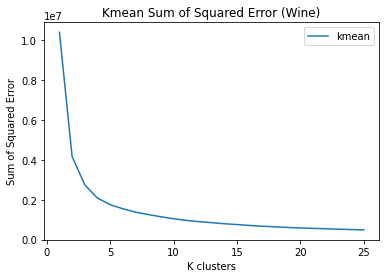

In [43]:
kmean(df_x,df_y, [i for i in range(1,26)], 'kmean-sse')

In [44]:
def sil(range_n_clusters, X, km, title):
    if km:
        cluster = KMeans(n_clusters=range_n_clusters, random_state=0)
    else:
        cluster = GaussianMixture(n_components=range_n_clusters, covariance_type='full')
    
    cluster_labels = cluster.fit_predict(X)
    for n_clusters in [range_n_clusters]:
        fig, (ax1) = plt.subplots(1)

        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = metrics.silhouette_score(X, cluster_labels)
        print(
            "For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg,
        )

        sample_silhouette_values = metrics.silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10  

        ax1.set_title("The Silhouette Plot for the "+title +'(Wine)')
        ax1.set_xlabel("The Silhouette Coefficient Values")
        ax1.set_ylabel("Cluster Label")
        ax1.axvline(x=silhouette_avg, color="orange", linestyle="--")

        ax1.set_yticks([])  
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


In [86]:
def cluster_plot(k, x, idx1, idx2):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(x)
    nodes = kmeans.cluster_centers_
    label = kmeans.predict(x)
    plt.scatter(x.to_numpy()[:,idx1], x.to_numpy()[:,idx2], marker=".", s=50, lw=2, c=label)
    plt.scatter(
        nodes[:, idx1],
        nodes[:, idx2],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k"
    )
    for i, n in enumerate(nodes):
        plt.scatter(n[idx1], n[idx2], marker="$%d$" % i, alpha=1, s=100)

    plt.title("KMean Clustering (Wine)")
    plt.xlabel("Feature space for the " +str(idx1)+ " feature")
    plt.ylabel("Feature space for the "+str(idx2)+" feature")


For n_clusters = 2 The average silhouette_score is : 0.5062782327329066
For n_clusters = 3 The average silhouette_score is : 0.41235155881165914
For n_clusters = 4 The average silhouette_score is : 0.3748324919135028
For n_clusters = 5 The average silhouette_score is : 0.3435489874849583
For n_clusters = 6 The average silhouette_score is : 0.3138217675667282
For n_clusters = 7 The average silhouette_score is : 0.3175074829237117
For n_clusters = 8 The average silhouette_score is : 0.31926385149621606
For n_clusters = 9 The average silhouette_score is : 0.3053858834069468
For n_clusters = 10 The average silhouette_score is : 0.3068076275291186
For n_clusters = 11 The average silhouette_score is : 0.2983769310908167
For n_clusters = 12 The average silhouette_score is : 0.29160793499658305
For n_clusters = 13 The average silhouette_score is : 0.29189244476029025
For n_clusters = 14 The average silhouette_score is : 0.2945233264767154
For n_clusters = 15 The average silhouette_score is : 0

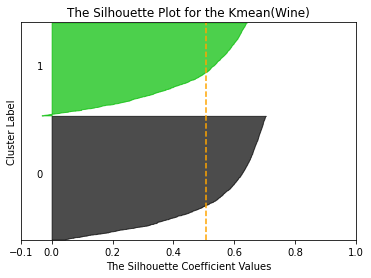

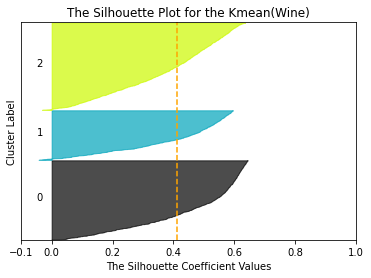

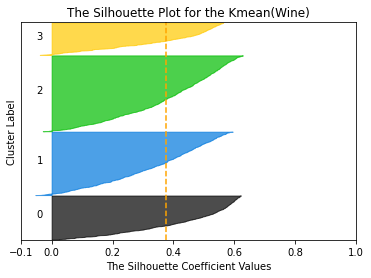

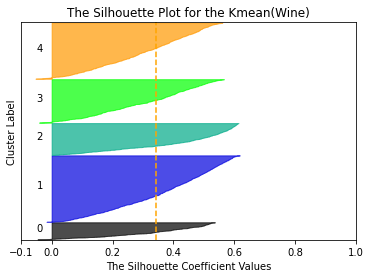

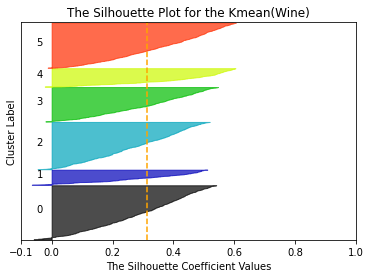

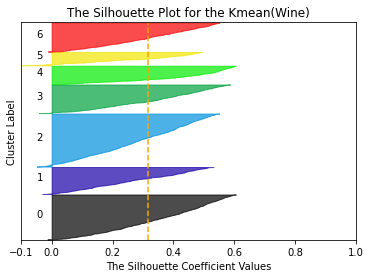

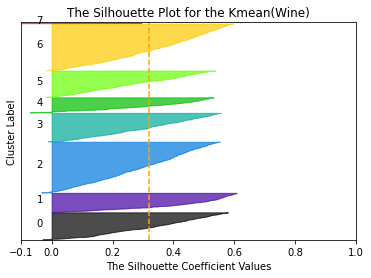

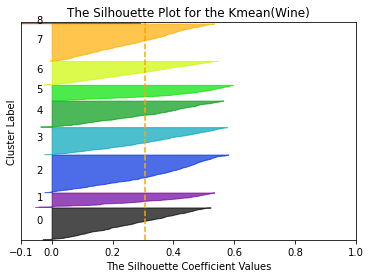

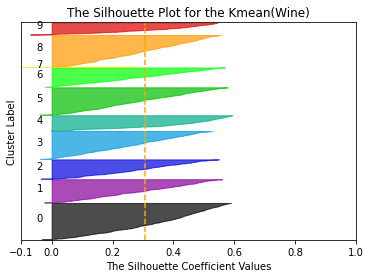

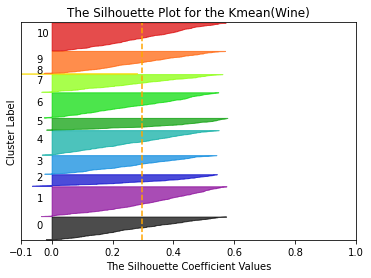

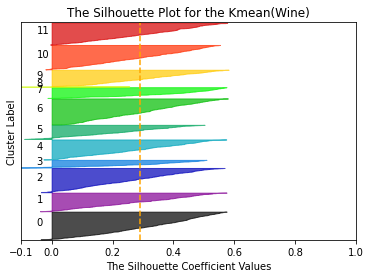

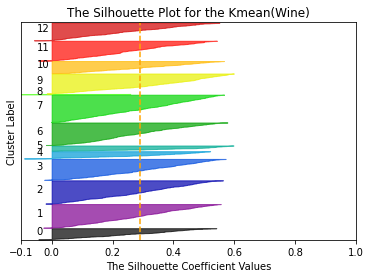

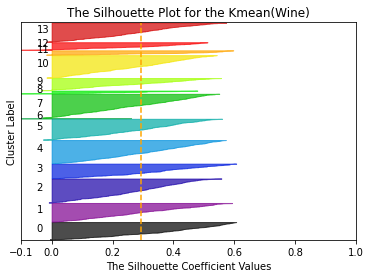

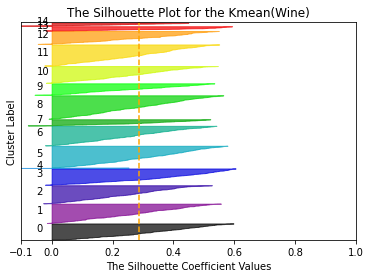

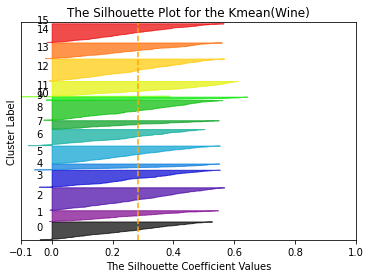

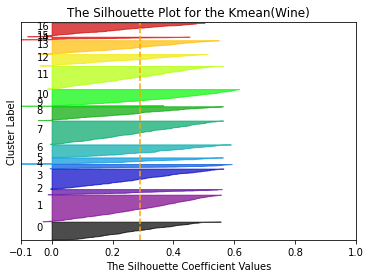

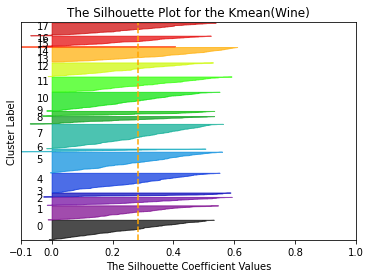

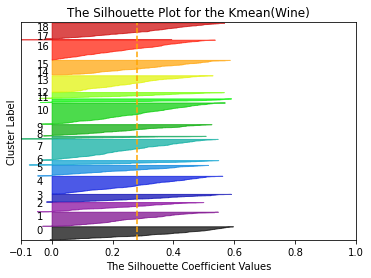

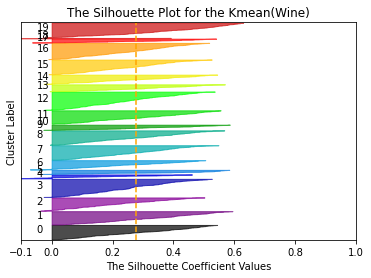

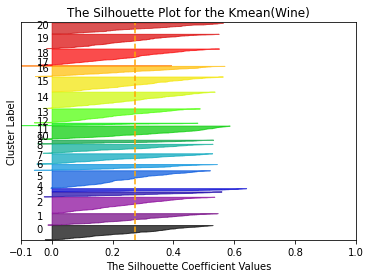

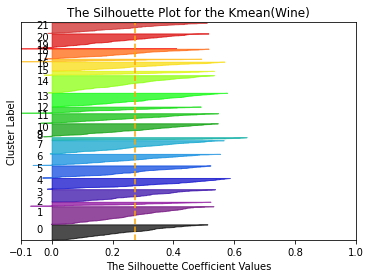

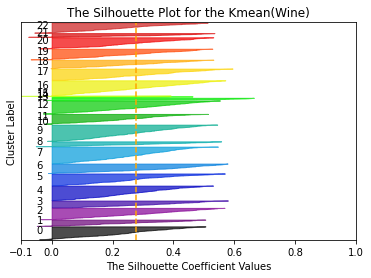

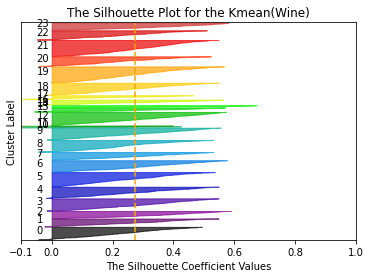

In [46]:
for i in range(2,25):
    sil(i, df_x, True, 'Kmean')

In [47]:
prediction(dkmean(df_x,2),df_y)

(0.5743565300285987,
 0.3698588090853284,
 0.3985300122498979,
 array([[ 747,  893],
        [2053, 1205]]),
 0.4126733069816886)

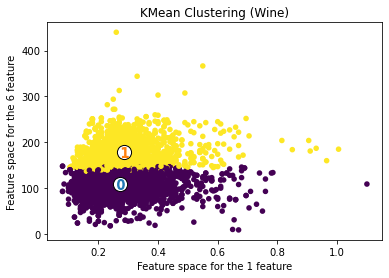

In [97]:
cluster_plot(2, df_x, 1, 6)

In [49]:
def em(x, y, rang, file):
    output = [[0 for i in range(25)] for j in range(4)]
    covar = ['full', 'tied', 'diag', 'spherical']
    for k in rang:
        for i, c in enumerate(covar):
            EM = GaussianMixture(n_components=k, random_state=0, covariance_type=c)
            EM.fit(x)
            output[i][k-1] = EM.score(x)
#             print(EM.converged_)
    plotting(covar, output, rang, 'Number of Components', 'Log-likelihood ', 'Expectation Maximization (Wine)', file)
        

In [50]:
def dem(x, k):
    EM = GaussianMixture(n_components=k, random_state=0, covariance_type='full')
    EM.fit(x)
    return EM.predict(x)

In [51]:
def combine(x1, x2):
    x1 = pd.DataFrame(x1)
    x1['new_feature'] = x2
    return x1

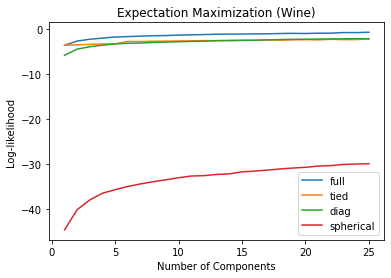

In [52]:
em(df_x, df_y, [i for i in range(1,26)], 'EM-LL')

For n_clusters = 2 The average silhouette_score is : 0.5062782327329066
For n_clusters = 3 The average silhouette_score is : 0.41235155881165914
For n_clusters = 4 The average silhouette_score is : 0.3748324919135028
For n_clusters = 5 The average silhouette_score is : 0.3435489874849583
For n_clusters = 6 The average silhouette_score is : 0.3138217675667282
For n_clusters = 7 The average silhouette_score is : 0.3175074829237117
For n_clusters = 8 The average silhouette_score is : 0.31926385149621606
For n_clusters = 9 The average silhouette_score is : 0.3053858834069468
For n_clusters = 10 The average silhouette_score is : 0.3068076275291186
For n_clusters = 11 The average silhouette_score is : 0.2983769310908167
For n_clusters = 12 The average silhouette_score is : 0.29160793499658305
For n_clusters = 13 The average silhouette_score is : 0.29189244476029025
For n_clusters = 14 The average silhouette_score is : 0.2945233264767154
For n_clusters = 15 The average silhouette_score is : 0

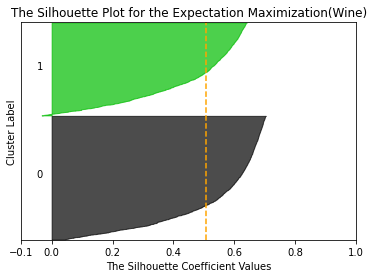

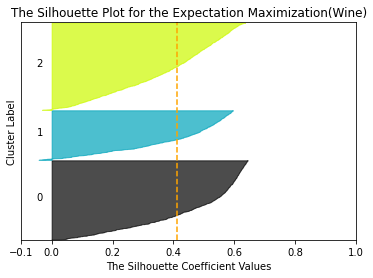

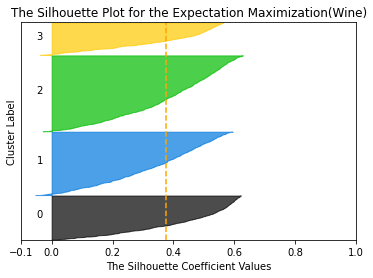

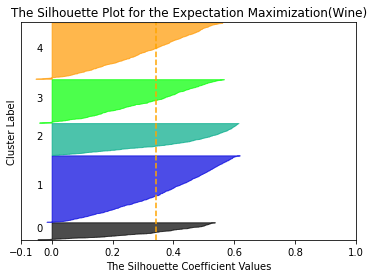

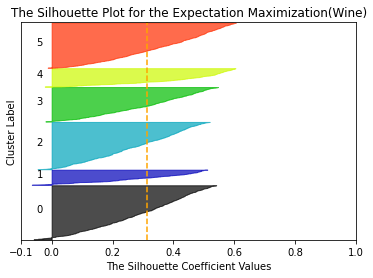

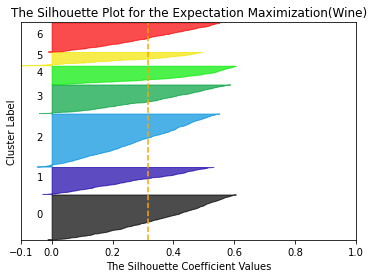

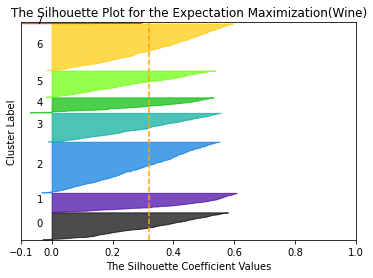

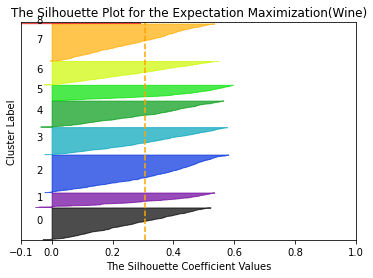

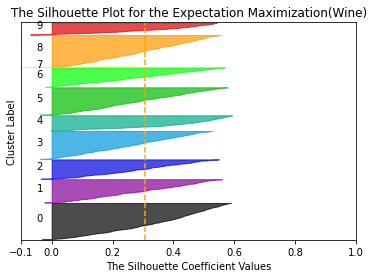

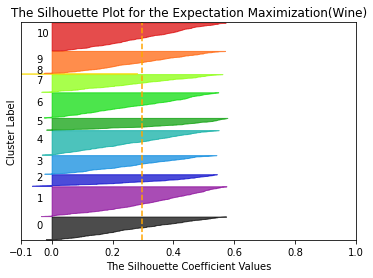

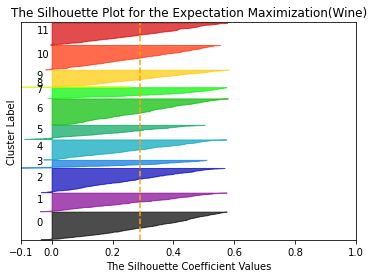

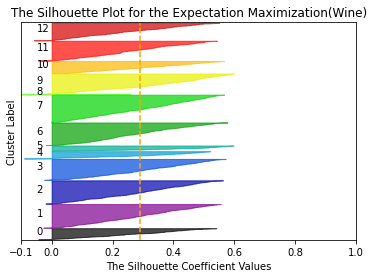

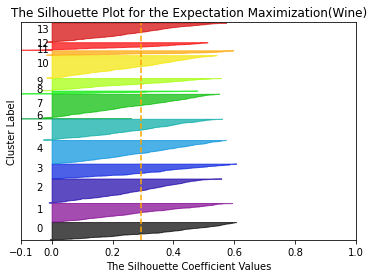

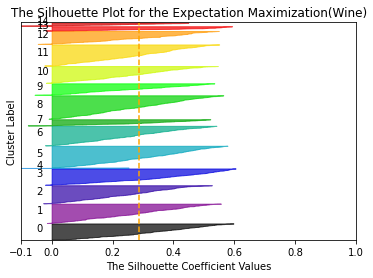

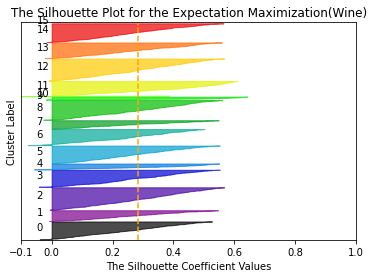

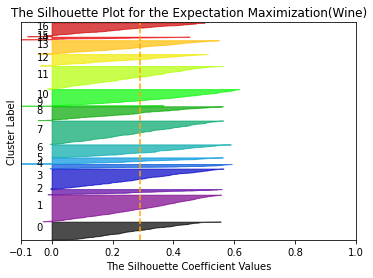

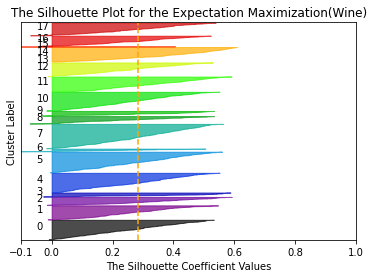

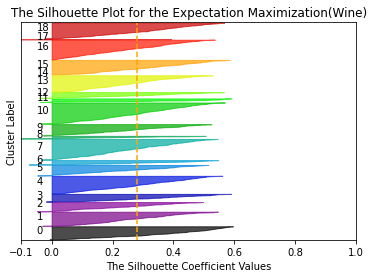

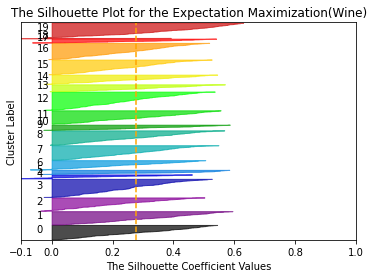

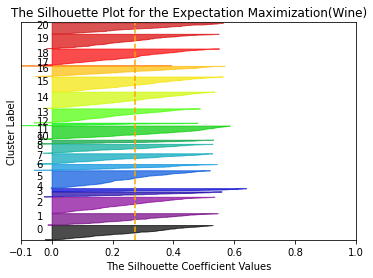

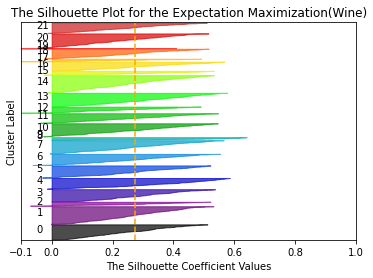

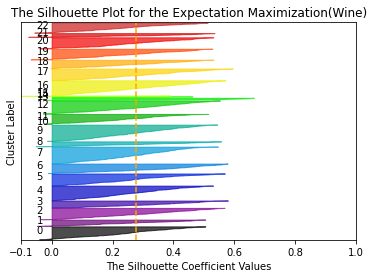

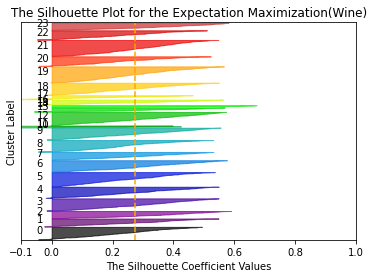

In [53]:
for i in range(2,25):
    sil(i, df_x, False, 'Expectation Maximization')

In [54]:
prediction(dem(df_x,2), df_y)

(0.34581105169340465,
 0.05954573357888275,
 0.2995100040832993,
 array([[1273,  367],
        [3064,  194]]),
 0.41788262288700234)

In [67]:
def pc(x, y, rang, file, cancer):
    pca = PCA( random_state=0)
    pca.fit(x)
    output = pca.explained_variance_ratio_
    plotting(['PCA'], [output], [i for i in range(len(output))],'Component Number', 'Variance Ratio', 'PCA Plot (Wine)', file)
    reduce_x = PCA(n_components = 2).fit_transform(x)
    print(reduce_x,reduce_x.shape,'features')
    kmean(reduce_x,y, [i for i in range(1,26)], 'pca-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'pca-EM-LL')
    for i in range(2,5):
        sil(i, reduce_x, True, 'PCA-Kmean')
        sil(i, reduce_x, False, 'PCA-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)

[[ 33.7327539    1.23828497]
 [-11.92579973 -18.95751887]
 [-41.22467147   5.73987365]
 ...
 [-27.99422284   1.98656157]
 [-31.62562278  -7.36798453]
 [-42.66909003  -2.30113142]] (4898, 2) features
For n_clusters = 2 The average silhouette_score is : 0.516428394672085
For n_clusters = 2 The average silhouette_score is : 0.516428394672085
For n_clusters = 3 The average silhouette_score is : 0.4267359944235024
For n_clusters = 3 The average silhouette_score is : 0.4267359944235024
For n_clusters = 4 The average silhouette_score is : 0.3937251619015032
For n_clusters = 4 The average silhouette_score is : 0.3937251619015032


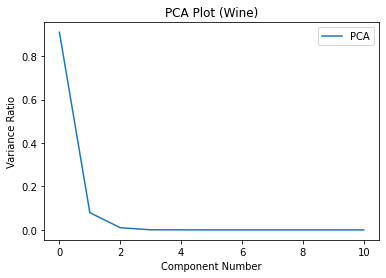

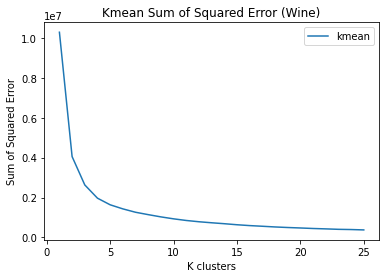

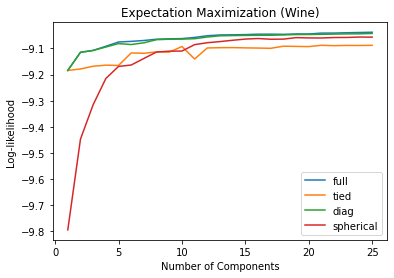

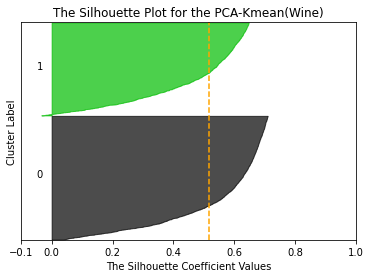

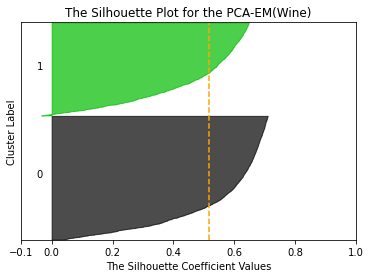

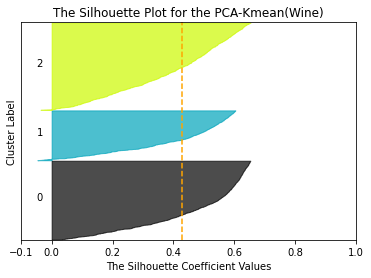

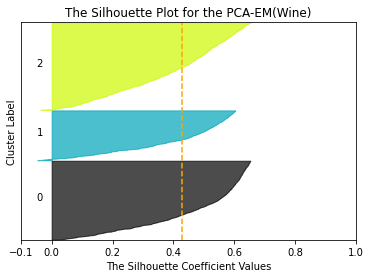

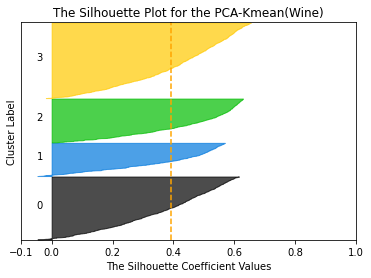

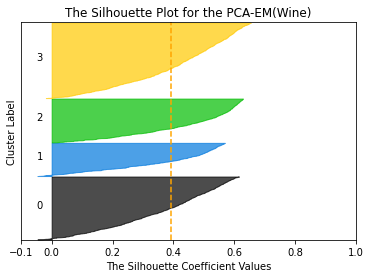

In [68]:
pc(df_x, df_y, None ,'pca', False)

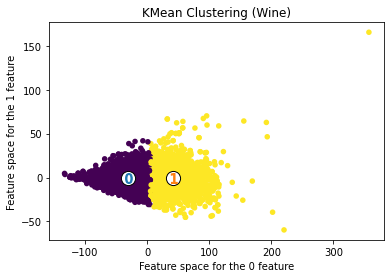

In [88]:
reduce_x = PCA(n_components = 2).fit_transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)

In [75]:
def ic(x, y, rang, file, cancer):
    kurt = []
    for i in rang:
        ica = FastICA(n_components=i, random_state=0)
        temp = ica.fit_transform(x)
        kurt.append(pd.DataFrame(temp).kurt(axis=0).abs().mean())
    plotting(['ICA'], [kurt], rang, 'Component Number', 'Normalized Kurtosis Value', 'ICA Kurtosis Value(Wine)', file)
   
    ica = FastICA(n_components=kurt.index(max(kurt)) + 1, random_state=0)
    reduce_x= ica.fit_transform(x)
    print(reduce_x,reduce_x.shape,'features')
    kmean(reduce_x,y, [i for i in range(1,26)], 'ICA-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'ICA-EM-LL')
    for i in range(2,11):
        sil(i, reduce_x, True, 'ICA-Kmean')
        sil(i, reduce_x, False, 'ICA-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)

[[ 0.0040944   0.00692456 -0.00247789 ...  0.02682302 -0.01292823
  -0.02162959]
 [-0.00382049  0.00113764 -0.00424719 ...  0.00410889 -0.00852386
   0.01824048]
 [-0.02164836 -0.00346755 -0.00155834 ... -0.00618328  0.01293981
  -0.02007744]
 ...
 [-0.01292934  0.00442541  0.0006677  ...  0.00765628  0.00279248
   0.00520801]
 [ 0.02454442  0.00955138 -0.01564556 ... -0.02234036  0.00067988
   0.0093975 ]
 [ 0.00943443  0.0120144  -0.01973195 ... -0.01890329  0.01040308
   0.00251503]] (4898, 11) features
For n_clusters = 2 The average silhouette_score is : 0.09272511606717336
For n_clusters = 2 The average silhouette_score is : 0.09272511606717336
For n_clusters = 3 The average silhouette_score is : 0.08593556980563437
For n_clusters = 3 The average silhouette_score is : 0.08593556980563437
For n_clusters = 4 The average silhouette_score is : 0.09565875301982624
For n_clusters = 4 The average silhouette_score is : 0.09565875301982624
For n_clusters = 5 The average silhouette_score is

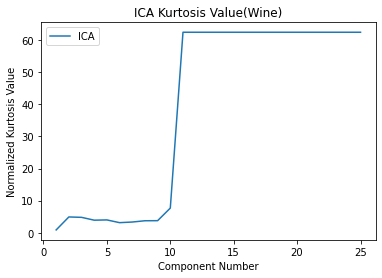

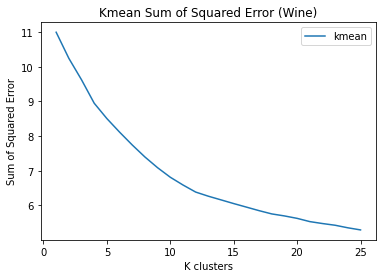

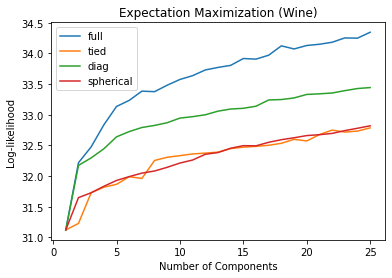

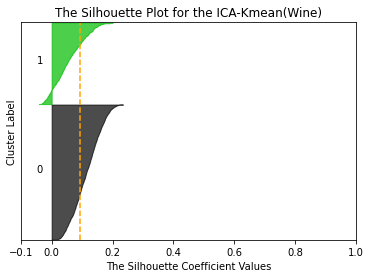

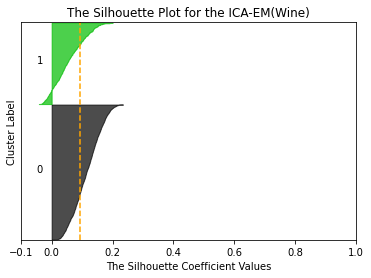

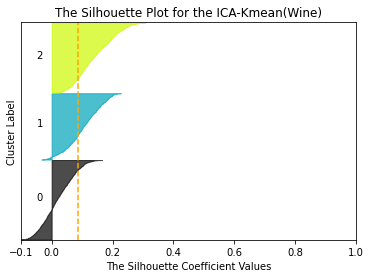

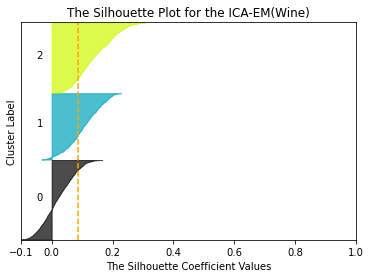

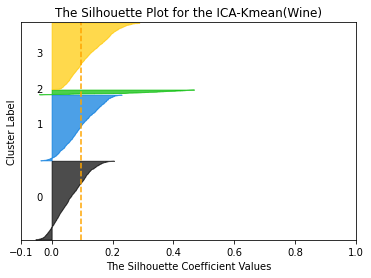

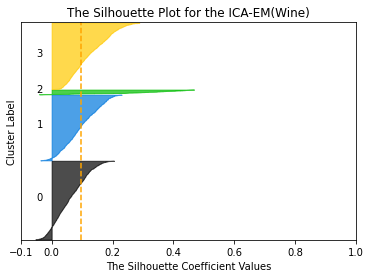

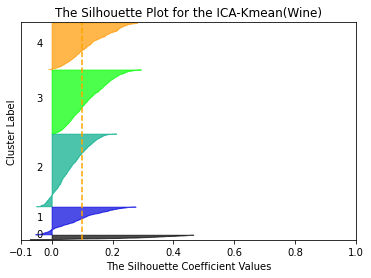

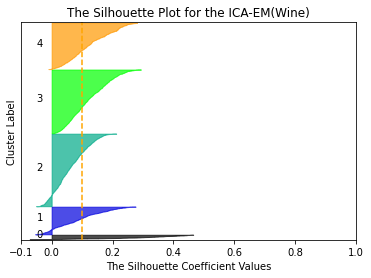

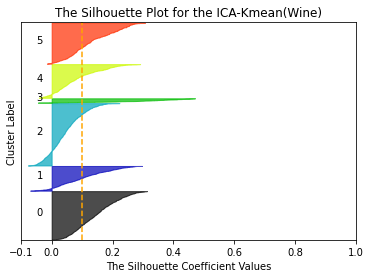

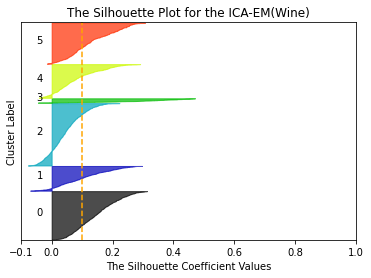

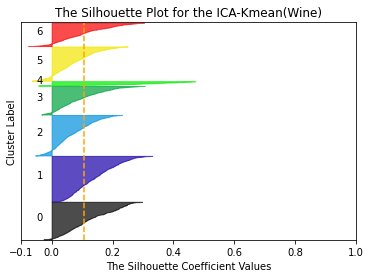

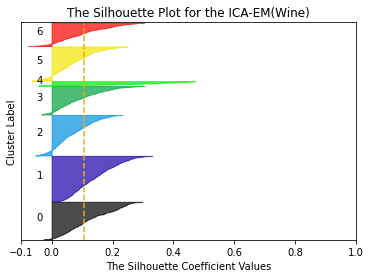

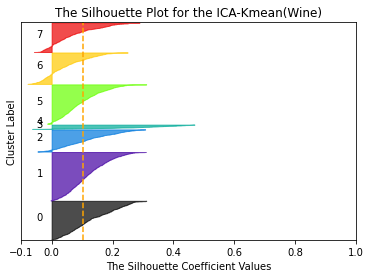

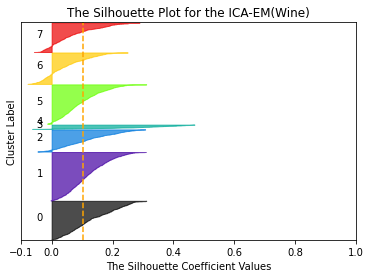

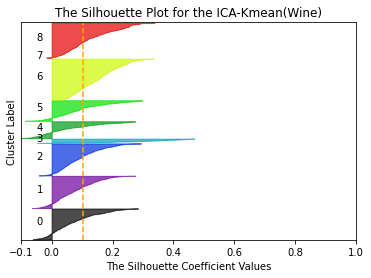

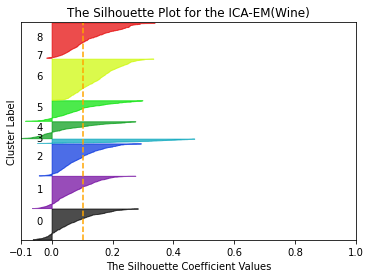

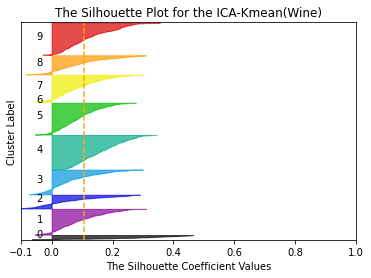

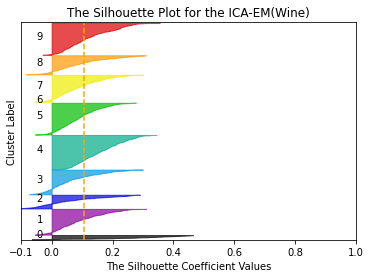

In [76]:
ic(df_x, df_y, [i for i in range(1,26)] ,'ica', False)

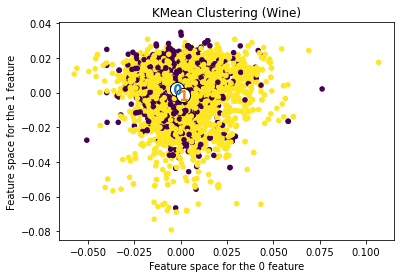

In [87]:
ica = FastICA(n_components=9, random_state=0)
reduce_x= ica.fit_transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)

In [71]:
def rd(x, y, rang, file, cancer):
    dic = defaultdict(dict)
    for r, i in product(rang, range(1,10)):
        rda = GaussianRandomProjection(n_components=i, random_state=r)
        reduce_x = rda.fit_transform(x)
        invs = pinv(rda.components_.T)
        recon =reduce_x.dot(invs)
        dic[i][r] = metrics.mean_squared_error(x,recon)
    rec = pd.DataFrame(dic).T
    rec_mean =  rec.mean(axis=1).tolist()
    rec_std = rec.std(axis=1).tolist()
    
    top = []
    bot = []
    zip_object = zip(rec_mean, rec_std)
    for l1, l2 in zip_object:
        top.append(l1 + l2)
        bot.append(l1 - l2)
        
   
    plt.plot(range(1, 10), rec_mean)
    plt.fill_between(range(1, 10), bot, top, alpha=0.2)
    plt.xlabel('Number of Components')
    plt.ylabel('Mean Reconstruction Error')
    plt.grid(False)
    plt.title(file + " Mean Reconstruction Error (Wine)")
    
    rda = GaussianRandomProjection(n_components=3, random_state=0)
    reduce_x = rda.fit_transform(x)
    print(reduce_x,reduce_x.shape,'features')
    kmean(reduce_x,y, [i for i in range(1,26)], 'RDA-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'RDA-EM-LL')
    for i in range(2,5):
        sil(i, reduce_x, True, 'RDA-Kmean')
        sil(i, reduce_x, False, 'RDA-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)

[[102.65749545  31.37490366 128.75314705]
 [ 73.93062806   3.72127441 113.79559877]
 [ 54.46522601  24.85386126  77.30737708]
 ...
 [ 52.96581941  20.19645834  93.76286298]
 [ 57.20824147  12.07730138  91.93358928]
 [ 49.55036093  15.28756089  82.23146611]] (4898, 3) features
For n_clusters = 2 The average silhouette_score is : 0.48476281163533685
For n_clusters = 2 The average silhouette_score is : 0.48476281163533685
For n_clusters = 3 The average silhouette_score is : 0.3939368974257048
For n_clusters = 3 The average silhouette_score is : 0.3939368974257048
For n_clusters = 4 The average silhouette_score is : 0.3476937659484182
For n_clusters = 4 The average silhouette_score is : 0.3476937659484182


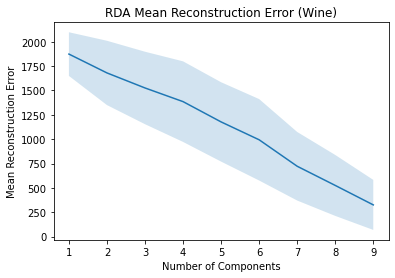

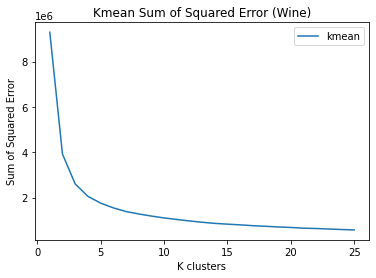

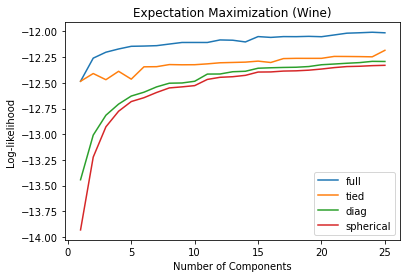

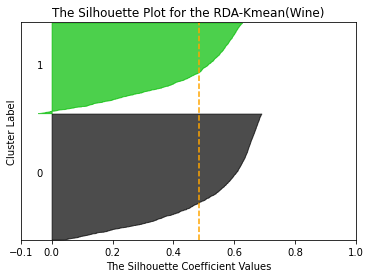

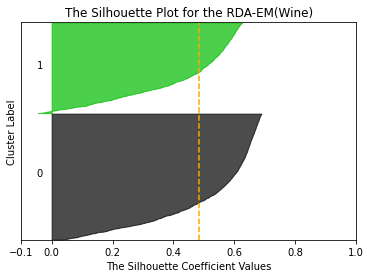

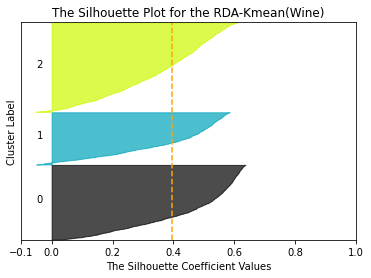

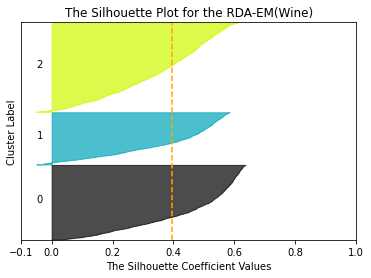

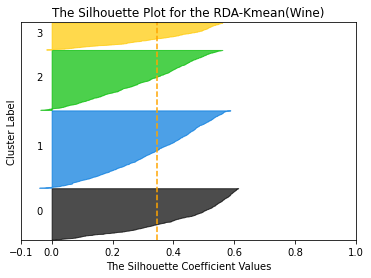

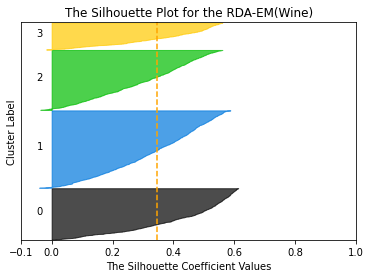

In [72]:
rd(df_x, df_y, range(50) ,'RDA', False)

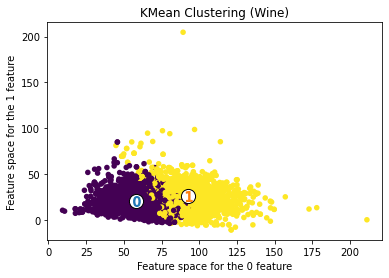

In [89]:
rda = GaussianRandomProjection(n_components=3, random_state=0)
reduce_x = rda.fit_transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)

In [73]:
def tree(x, y, rang, file, cancer):
    feature_names = x_features
    rdc =  RandomForestClassifier(random_state=0)
    rdc = rdc.fit(x,y)
    importances = rdc.feature_importances_
    print(importances)
    std = np.std([rdc.feature_importances_ for rdc in rdc.estimators_], axis=0)
    
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature Importances using Mean Decrease in Impurity (Wine)")
    ax.set_ylabel("Mean Decrease in Impurity")
    fig.tight_layout()
    
    select = SelectFromModel(rdc, prefit=True)
    reduce_x = select.transform(x)
    print(reduce_x,reduce_x.shape,'features')
    kmean(reduce_x,y, [i for i in range(1,26)], 'Tree-kmean-sse')
    em(reduce_x, y, [i for i in range(1,26)], 'Tree-EM-LL')
    for i in range(2,5):
        sil(i, reduce_x, True, 'Tree-Kmean')
        sil(i, reduce_x, False, 'Tree-EM')
    if cancer:
        X_train, X_test, Y_train, Y_test = train_test_split(reduce_x, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        new_x2 = dkmean(reduce_x, 2)
        new_x3 = dem(reduce_x, 2)
        x2 = combine(reduce_x, new_x2)
        x3 = combine(reduce_x, new_x3)
        X_train, X_test, Y_train, Y_test = train_test_split(x2, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)
        X_train, X_test, Y_train, Y_test = train_test_split(x3, y, test_size=0.2)
        nn_output = nn(X_train, Y_train, X_test, Y_test)

[0.06429322 0.1140619  0.08194015 0.08189696 0.08279272 0.09654718
 0.0873633  0.10787175 0.0727247  0.06479025 0.14571787]
[[ 0.27    45.       1.001    8.8    ]
 [ 0.3     14.       0.994    9.5    ]
 [ 0.28    30.       0.9951  10.1    ]
 ...
 [ 0.24    30.       0.99254  9.4    ]
 [ 0.29    20.       0.98869 12.8    ]
 [ 0.21    22.       0.98941 11.8    ]] (4898, 4) features
For n_clusters = 2 The average silhouette_score is : 0.5650241789001684
For n_clusters = 2 The average silhouette_score is : 0.5650241789001684
For n_clusters = 3 The average silhouette_score is : 0.517733862057226
For n_clusters = 3 The average silhouette_score is : 0.517733862057226
For n_clusters = 4 The average silhouette_score is : 0.5125539777068748
For n_clusters = 4 The average silhouette_score is : 0.5125539777068748


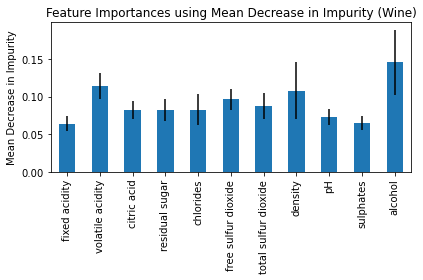

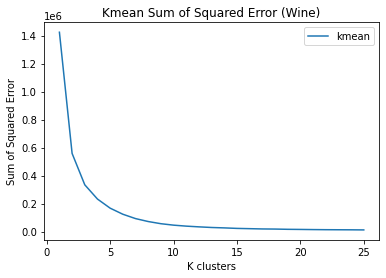

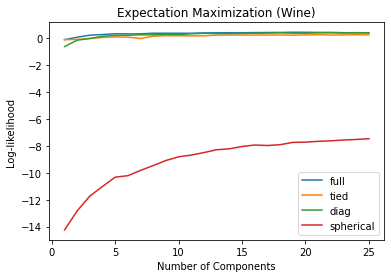

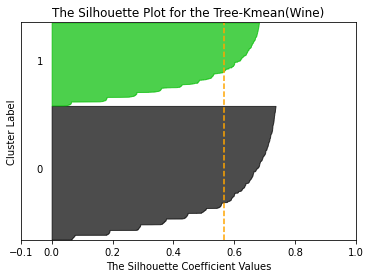

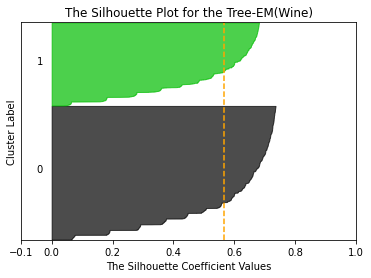

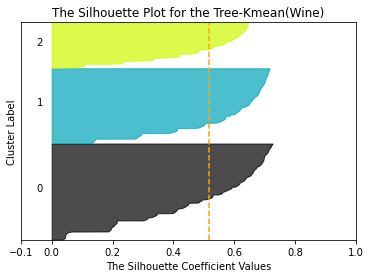

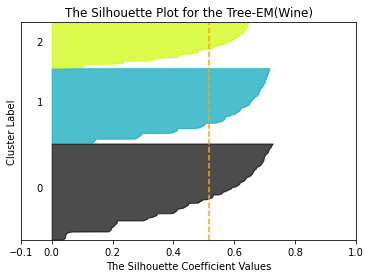

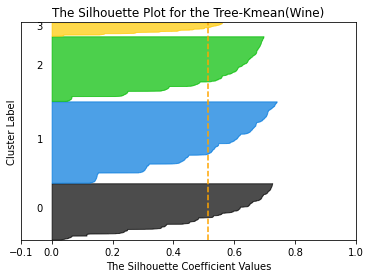

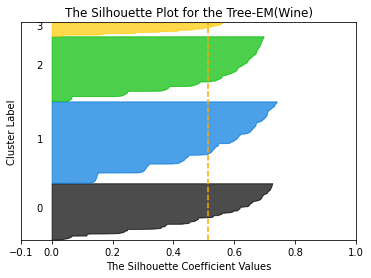

In [74]:
tree(df_x, df_y, range(1,26) ,'RDC', False)

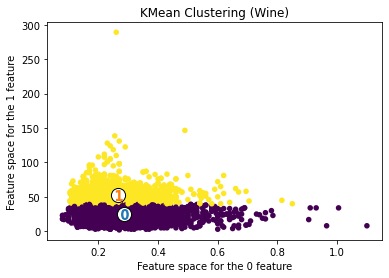

In [90]:
rdc =  RandomForestClassifier(random_state=0)
rdc = rdc.fit(df_x,df_y)
select = SelectFromModel(rdc, prefit=True)
reduce_x = select.transform(df_x)
cluster_plot(2, pd.DataFrame(reduce_x), 0, 1)